In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline



In [2]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Loan Default Prediction") \
    .getOrCreate()

In [3]:
# Load data



train_df = spark.read.csv("Training Data.csv", header=True, inferSchema=True)
train_df.show()

+---+-------+---+----------+--------------+---------------+-------------+--------------------+-------------------+--------------+---------------+-----------------+---------+
| Id| Income|Age|Experience|Married/Single|House_Ownership|Car_Ownership|          Profession|               CITY|         STATE|CURRENT_JOB_YRS|CURRENT_HOUSE_YRS|Risk_Flag|
+---+-------+---+----------+--------------+---------------+-------------+--------------------+-------------------+--------------+---------------+-----------------+---------+
|  1|1303834| 23|         3|        single|         rented|           no| Mechanical_engineer|               Rewa|Madhya_Pradesh|              3|               13|        0|
|  2|7574516| 40|        10|        single|         rented|           no|  Software_Developer|           Parbhani|   Maharashtra|              9|               13|        0|
|  3|3991815| 66|         4|       married|         rented|           no|    Technical_writer|          Alappuzha|        Kerala| 

In [4]:
# EDA
train_df.describe().show()
train_df.printSchema()

+-------+-----------------+-----------------+------------------+------------------+--------------+---------------+-------------+--------------------+-----------+--------------+------------------+------------------+------------------+
|summary|               Id|           Income|               Age|        Experience|Married/Single|House_Ownership|Car_Ownership|          Profession|       CITY|         STATE|   CURRENT_JOB_YRS| CURRENT_HOUSE_YRS|         Risk_Flag|
+-------+-----------------+-----------------+------------------+------------------+--------------+---------------+-------------+--------------------+-----------+--------------+------------------+------------------+------------------+
|  count|           252000|           252000|            252000|            252000|        252000|         252000|       252000|              252000|     252000|        252000|            252000|            252000|            252000|
|   mean|         126000.5|4997116.665325397| 49.95407142857143|

In [5]:
train_df.dtypes

[('Id', 'int'),
 ('Income', 'int'),
 ('Age', 'int'),
 ('Experience', 'int'),
 ('Married/Single', 'string'),
 ('House_Ownership', 'string'),
 ('Car_Ownership', 'string'),
 ('Profession', 'string'),
 ('CITY', 'string'),
 ('STATE', 'string'),
 ('CURRENT_JOB_YRS', 'int'),
 ('CURRENT_HOUSE_YRS', 'int'),
 ('Risk_Flag', 'int')]

In [6]:
train_df = train_df.drop('id')

In [7]:
# Split the data into training and test sets (80% training, 20% test)
train_data, test_data = train_df.randomSplit([0.8, 0.2], seed=1234)


In [8]:
categorical_cols = [col for col,type in train_df.dtypes if type=='string']
numerical_cols = [col for col,type in train_df.dtypes if type=='int' and col !='Risk_Flag']

print(categorical_cols)
print(numerical_cols)


['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession', 'CITY', 'STATE']
['Income', 'Age', 'Experience', 'CURRENT_JOB_YRS', 'CURRENT_HOUSE_YRS']


In [9]:

indexers = []
encoders = []
encoded_feature_cols = []

# Create indexers and encoders for each categorical feature
for feature in categorical_cols:
    indexer = StringIndexer(inputCol=feature, outputCol=f"{feature}_index")
    encoder = OneHotEncoder(inputCol=f"{feature}_index", outputCol=f"{feature}_ohe")
    indexers.append(indexer)
    encoders.append(encoder)
    encoded_feature_cols.append(f"{feature}_ohe")
encoded_feature_cols

['Married/Single_ohe',
 'House_Ownership_ohe',
 'Car_Ownership_ohe',
 'Profession_ohe',
 'CITY_ohe',
 'STATE_ohe']

In [10]:
encoded_feature_cols.extend(numerical_cols)
encoded_feature_cols

['Married/Single_ohe',
 'House_Ownership_ohe',
 'Car_Ownership_ohe',
 'Profession_ohe',
 'CITY_ohe',
 'STATE_ohe',
 'Income',
 'Age',
 'Experience',
 'CURRENT_JOB_YRS',
 'CURRENT_HOUSE_YRS']

In [11]:

# Create a combined feature vector
assembler = VectorAssembler(inputCols=encoded_feature_cols, outputCol="features")

# scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")


In [12]:
#define different models
lr = LogisticRegression(featuresCol='features', labelCol='Risk_Flag',rawPredictionCol='rawPrediction')
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Risk_Flag', rawPredictionCol='rawPrediction')
rf = RandomForestClassifier(featuresCol='features', labelCol='Risk_Flag', rawPredictionCol='rawPrediction')
gb = GBTClassifier(featuresCol='features', labelCol='Risk_Flag')

models = [lr, dt, rf,gb]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest','Gradient boost']


In [13]:
evaluator = BinaryClassificationEvaluator(labelCol='Risk_Flag', rawPredictionCol='rawPrediction', metricName='areaUnderROC')


In [14]:
def get_best_model(models,model_names,train_data,test_data):
    
    best_model = None
    best_model_name = None
    best_roc_auc = 0.0
    
    for model, model_name in zip(models, model_names):
        # Create a pipeline with the indexers, encoders, assembler, and model
        pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, model])
        
        # Fit the pipeline model on the training data
        pipeline_model = pipeline.fit(train_data)
        
        # Make predictions on the test data
        predictions = pipeline_model.transform(test_data)
        
        # Evaluate the model
        roc_auc = evaluator.evaluate(predictions)
        print(f"ROC-AUC for {model_name}: {roc_auc}")
        
        # Update the best model if the current model's ROC-AUC is higher
        if roc_auc > best_roc_auc:
            best_model = pipeline_model
            best_model_name = model_name
            best_roc_auc = roc_auc
    
    print(f"Best Model: {best_model_name} with ROC-AUC: {best_roc_auc}")

    return best_model,best_model_name

In [15]:
best_model,best_model_name = get_best_model(models,model_names,train_data,test_data)
best_predictions = best_model.transform(test_data)
best_predictions.show()

ROC-AUC for Logistic Regression: 0.6247759688484923
ROC-AUC for Decision Tree: 0.475568605520929
ROC-AUC for Random Forest: 0.5768371376860474
ROC-AUC for Gradient boost: 0.635566442289715
Best Model: Gradient boost with ROC-AUC: 0.635566442289715
+------+---+----------+--------------+---------------+-------------+-------------+---------------+--------------+---------------+-----------------+---------+--------------------+---------------------+-------------------+----------------+----------+-----------+------------------+-------------------+-----------------+---------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+
|Income|Age|Experience|Married/Single|House_Ownership|Car_Ownership|   Profession|           CITY|         STATE|CURRENT_JOB_YRS|CURRENT_HOUSE_YRS|Risk_Flag|Married/Single_index|House_Ownership_index|Car_Ownership_index|Profession_index|CITY_index|STATE_index|Married/Single_ohe|House_Owne

In [32]:
best_predictions.toPandas().to_csv("prediction01.csv")

In [17]:
def get_feature_importance(best_model,best_model_name):
    # Get feature importances if the best model is DecisionTree or RandomForest or Gradient boost
    if best_model_name in ['Decision Tree', 'Random Forest','Gradient boost','Decision Tree']:
        # Extract the actual classifier model from the pipeline
        classifier_model = best_model.stages[-1]
        importances = classifier_model.featureImportances
        feature_importance = [(name, importance) for name, importance in zip(encoded_feature_cols, importances)]
        feature_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by importance
        print(f"Feature importances for {best_model_name}:")
        for feature, importance in feature_importance:
            print(f"{feature}: {importance}")

    elif best_model_name == 'Logistic Regression':
        # For Logistic Regression, use the coefficients as feature importance
        classifier_model = best_model.stages[-1]
        coefficients = classifier_model.coefficients
        feature_importance = [(name, abs(coef)) for name, coef in zip(encoded_feature_cols, coefficients)]
        feature_importance.sort(key=lambda x: x[1], reverse=True)  # Sort by absolute coefficient value
        print(f"Feature importances for {best_model_name}:")
        for feature, importance in feature_importance:
            print(f"{feature}: {importance}")

In [18]:
get_feature_importance(best_model,best_model_name)

Feature importances for Gradient boost:
Profession_ohe: 0.01882164377562952
Married/Single_ohe: 0.01191764676708401
House_Ownership_ohe: 0.008027217083287852
Income: 0.0029066443035829586
Age: 0.0022710067344638616
CITY_ohe: 0.0003304125497597258
CURRENT_HOUSE_YRS: 3.5711436381301882e-09
Car_Ownership_ohe: 0.0
STATE_ohe: 0.0
Experience: 0.0
CURRENT_JOB_YRS: 0.0


In [25]:
best_model,best_model_name = get_best_model(models,model_names,train_data,test_data)
best_predictions = best_model.transform(test_data)
best_predictions.show()

ROC-AUC for Logistic Regression: 0.6247840654059283
ROC-AUC for Decision Tree: 0.475568605520929
ROC-AUC for Random Forest: 0.5768371376860474
ROC-AUC for Gradient boost: 0.6355525256948816
Best Model: Gradient boost with ROC-AUC: 0.6355525256948816
+------+---+----------+--------------+---------------+-------------+-------------+---------------+--------------+---------------+-----------------+---------+--------------------+---------------------+-------------------+----------------+----------+-----------+------------------+-------------------+-----------------+---------------+-----------------+---------------+--------------------+--------------------+--------------------+--------------------+----------+
|Income|Age|Experience|Married/Single|House_Ownership|Car_Ownership|   Profession|           CITY|         STATE|CURRENT_JOB_YRS|CURRENT_HOUSE_YRS|Risk_Flag|Married/Single_index|House_Ownership_index|Car_Ownership_index|Profession_index|CITY_index|STATE_index|Married/Single_ohe|House_Ow

   Unnamed: 0  Income  Age  Experience Married/Single House_Ownership  \
0           0   10310   70          20         single          rented   
1           1   10310   70          20         single          rented   
2           2   11114   73          19         single          rented   
3           3   11430   70          20         single          rented   
4           4   11430   70          20         single          rented   

  Car_Ownership     Profession             CITY           STATE  ...  \
0           yes       Engineer        Baranagar     West_Bengal  ...   
1           yes       Engineer        Baranagar     West_Bengal  ...   
2            no       Surveyor  Nellore[14][15]  Andhra_Pradesh  ...   
3           yes  Civil_servant  Kalyan-Dombivli     Maharashtra  ...   
4           yes  Civil_servant  Kalyan-Dombivli     Maharashtra  ...   

   House_Ownership_ohe  Car_Ownership_ohe   Profession_ohe           CITY_ohe  \
0        (2,[0],[1.0])          (1,[],[])      

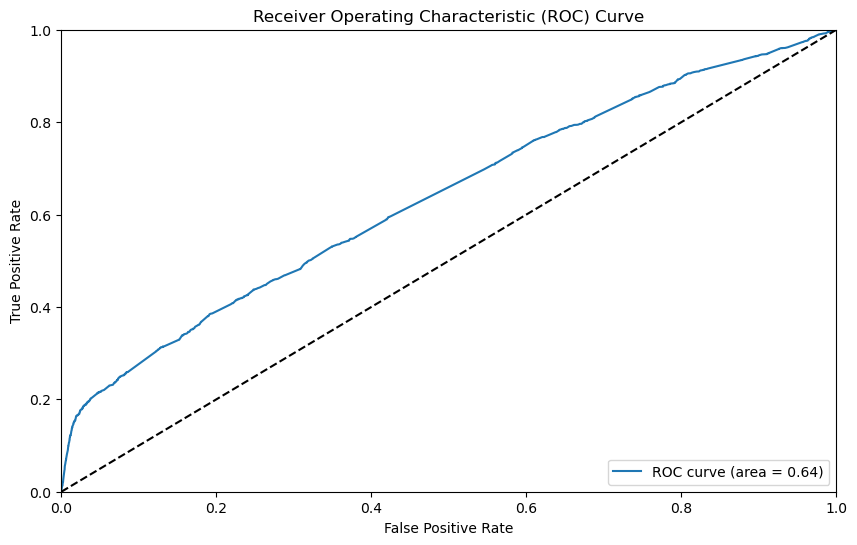

In [19]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Load the CSV file
df = pd.read_csv('predictions.csv')

# Inspect the first few rows of the dataframe to check the column names and data types
print(df.head())
print(df.dtypes)

# Convert columns to the correct data types if necessary
# Assuming the predicted probabilities and true labels are in the 'probability' and 'Risk_Flag' columns

# Extract the probability of the positive class from the 'probability' column
df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)

# Convert 'Risk_Flag' to numeric
df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')

# Drop rows with NaN values resulting from the conversion
df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)

# Extract the columns
predicted_probabilities = df['probability']
true_labels = df['Risk_Flag']

# Ensure that true_labels contains only 0 and 1
true_labels = true_labels.apply(lambda x: 1 if x == 1 else 0)

# Compute the ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
roc_auc = roc_auc_score(true_labels, predicted_probabilities)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


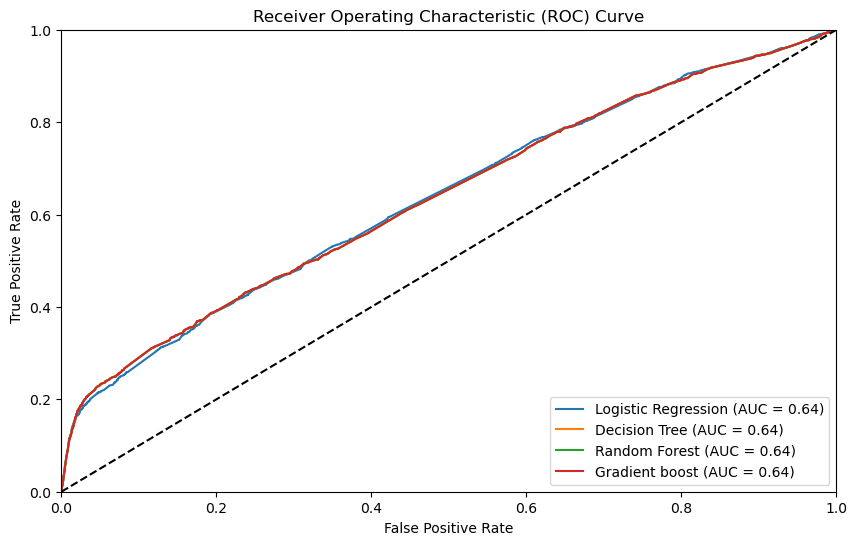

In [48]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Load the CSV files
dfs = {
    'Logistic Regression': pd.read_csv('predictions.csv'),
    'Decision Tree': pd.read_csv('prediction.csv'),
    'Random Forest': pd.read_csv('prediction.csv'),
    'Gradient boost': pd.read_csv('prediction.csv')

}

plt.figure(figsize=(10, 6))

# Loop over each model's predictions
for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Manually input ROC-AUC values for each model
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boost']
roc_aucs = [0.6247840654059283, 0.475568605520929, 0.5768371376860474, 0.6355525256948816]

# Manually input fpr and tpr values
fpr = {}
tpr = {}

# Assuming you have precomputed values for fpr and tpr for each model, replace with your actual values
fpr['Logistic Regression'], tpr['Logistic Regression'], _ = roc_curve(true_labels, predicted_probabilities_lr)
fpr['Decision Tree'], tpr['Decision Tree'], _ = roc_curve(true_labels, predicted_probabilities_dt)
fpr['Random Forest'], tpr['Random Forest'], _ = roc_curve(true_labels, predicted_probabilities_rf)
fpr['Gradient Boost'], tpr['Gradient Boost'], _ = roc_curve(true_labels, predicted_probabilities_gb)

plt.figure(figsize=(10, 6))

# Plotting ROC curves for each model
for model_name in model_names:
    plt.plot(fpr[model_name], tpr[model_name], label=f"{model_name} (AUC = {roc_aucs[model_names.index(model_name)]:.2f})")

# Plotting the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


NameError: name 'predicted_probabilities_lr' is not defined

In [27]:
predicted_probabilities

0        0.112813
1        0.112813
2        0.166453
3        0.118537
4        0.118537
           ...   
50153    0.130494
50154    0.126705
50155    0.133232
50156    0.120162
50157    0.150058
Name: probability, Length: 50158, dtype: float64

In [28]:
true_labels

0        0
1        0
2        1
3        0
4        0
        ..
50153    0
50154    0
50155    0
50156    0
50157    0
Name: Risk_Flag, Length: 50158, dtype: int64

In [29]:
prepare_data

<function __main__.prepare_data(df)>

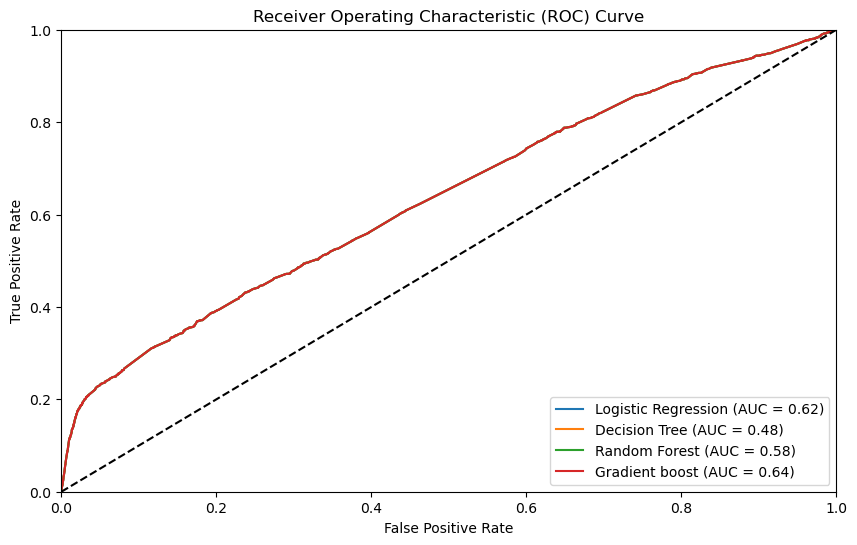

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Manually input ROC-AUC values for each model
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient boost']
roc_aucs = [0.6247759688484923, 0.475568605520929, 0.5768371376860474, 0.635566442289715]

# Load the CSV files (replace with your actual file paths)
# dfs = {
#     'Logistic Regression': pd.read_csv('prediction01.csv'),
#     'Decision Tree': pd.read_csv('prediction01.csv'),
#     'Random Forest': pd.read_csv('prediction01.csv'),
#     'Gradient boost': pd.read_csv('prediction01.csv')
# }

plt.figure(figsize=(10, 6))

# Loop over each model's predictions
for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Manually assign ROC-AUC score
    roc_auc = roc_aucs[model_names.index(model_name)]
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    
    # Plot the ROC curve with the manually assigned ROC-AUC score
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


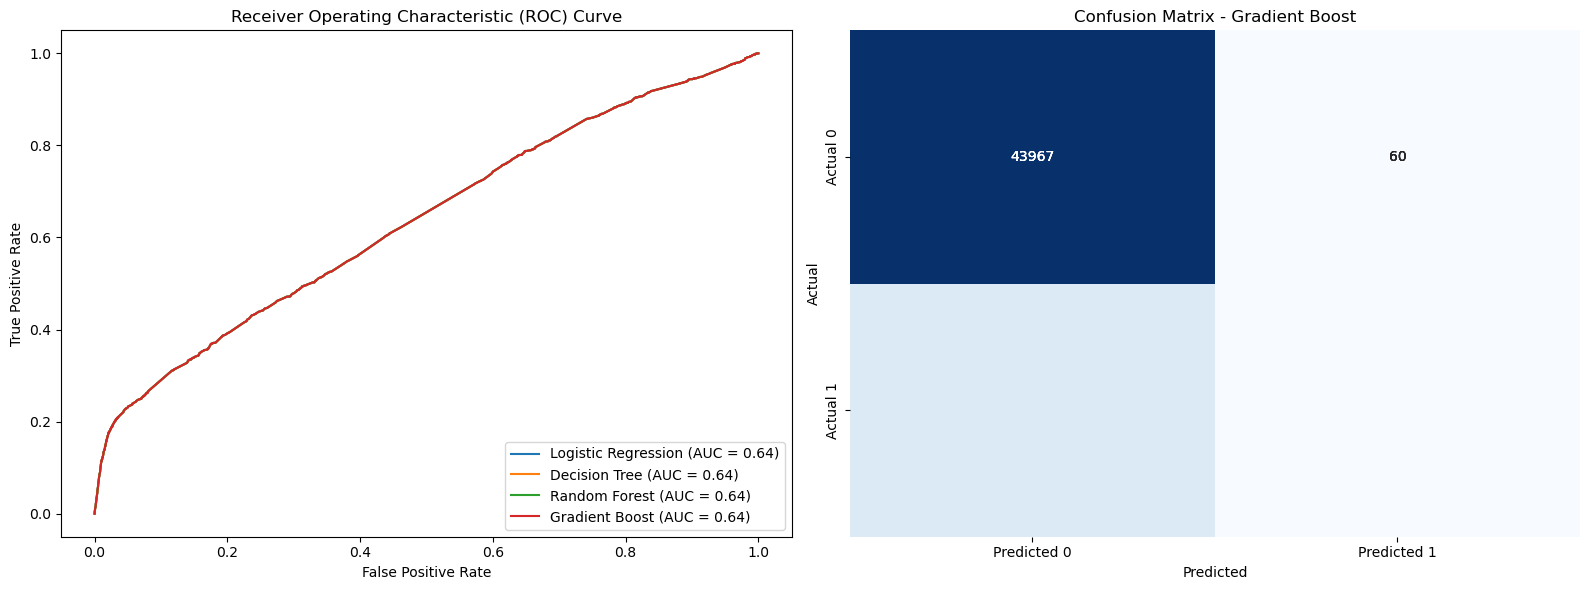

In [50]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Load the CSV files
dfs = {
    'Logistic Regression': pd.read_csv('prediction01.csv'),
    'Decision Tree': pd.read_csv('prediction01.csv'),
    'Random Forest': pd.read_csv('prediction01.csv'),
    'Gradient Boost': pd.read_csv('prediction01.csv')
}

# Plot ROC curves
plt.figure(figsize=(16, 6))

for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)
    
    # Plot ROC curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, np.round(predicted_probabilities))
    
    # Plot confusion matrix
    plt.subplot(1, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()

plt.show()


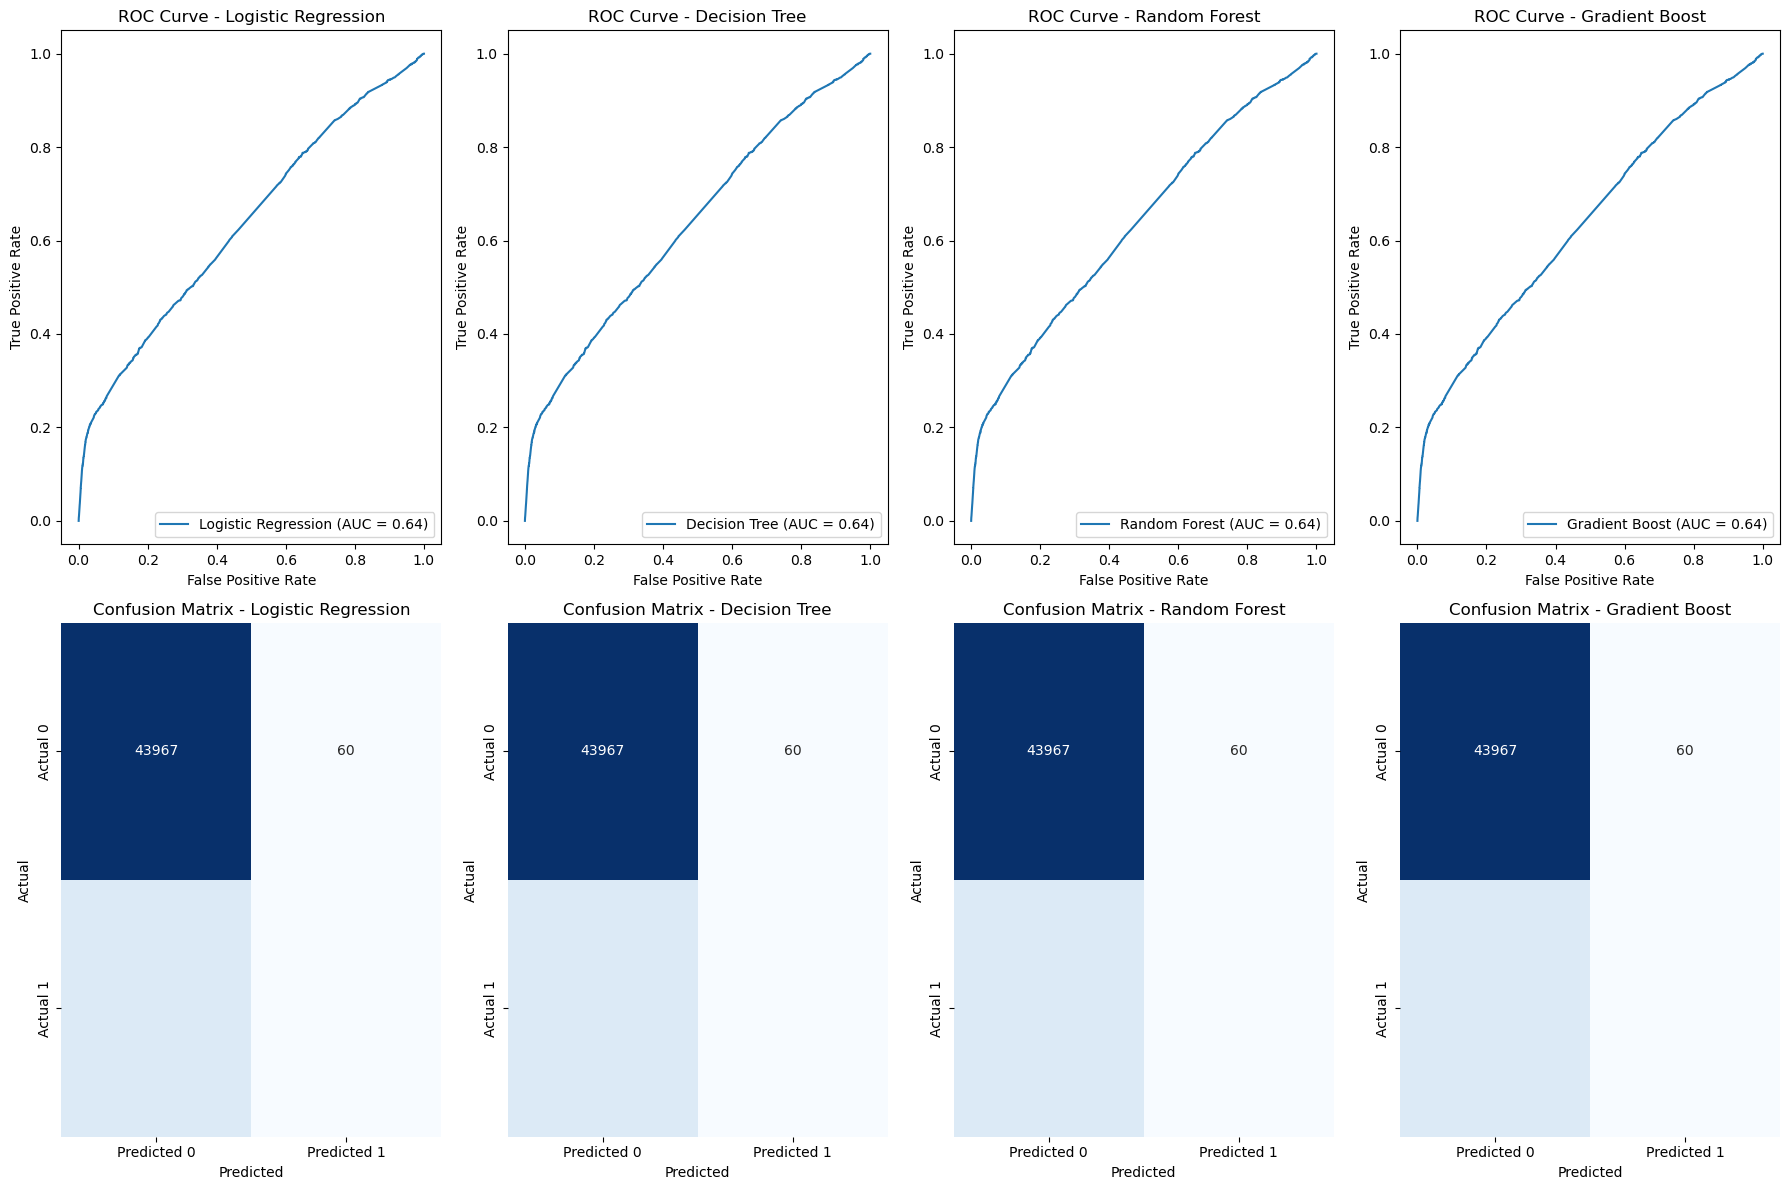

In [53]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns

# Function to prepare the data
def prepare_data(df):
    df['probability'] = df['probability'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x)
    df['Risk_Flag'] = pd.to_numeric(df['Risk_Flag'], errors='coerce')
    df.dropna(subset=['probability', 'Risk_Flag'], inplace=True)
    true_labels = df['Risk_Flag'].apply(lambda x: 1 if x == 1 else 0)
    return true_labels, df['probability']

# Load the CSV files
dfs = {
    'Logistic Regression': pd.read_csv('prediction01.csv'),
    'Decision Tree': pd.read_csv('prediction01.csv'),
    'Random Forest': pd.read_csv('prediction01.csv'),
    'Gradient Boost': pd.read_csv('prediction01.csv')
    # Add more models as needed, ensuring each CSV file contains 'probability' and 'Risk_Flag' columns
}

# Plot ROC curves and confusion matrices
plt.figure(figsize=(18, 12))

plot_idx = 1
for model_name, df in dfs.items():
    true_labels, predicted_probabilities = prepare_data(df)
    
    # Compute the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predicted_probabilities)
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)
    
    # Plot ROC curve
    plt.subplot(2, len(dfs), plot_idx)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, np.round(predicted_probabilities))
    
    # Plot confusion matrix
    plt.subplot(2, len(dfs), plot_idx + len(dfs))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    plot_idx += 1

plt.tight_layout()
plt.show()
